<a href="https://colab.research.google.com/github/sr33kar/major_project/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
#!pip install torch==0.4.0 torchvision==0.2

!pip3 install torch===0.4.1.post2 torchvision===0.2.0 -f  https://download.pytorch.org/whl/torch_stable.html
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
#/content/drive/MyDrive/Colab Notebooks/data.ipynb
#/content/drive/MyDrive/Colab Notebooks/train.ipynb


#sys.path.append('/content/drive/My\ Drive') #folder which contains model,





Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 519.5MB 33kB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 0.4.1.post2 which is incompatible.
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.4.1.post2 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
print(torch.__version__)

0.4.1.post2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/toy

# List files to make sure we're in the expected directory.
# Your output will look different, showing your own Drive files here.
!ls

/content/drive/My Drive/toy
coord.pth  noise.pth  toy


In [ ]:
import torch
import torch.utils.data as data
import random


class ToyTask(data.Dataset):
    """
    This toy task is intended to test the robustness of the approach, not so much to be "fair" to other baselines.
    """
    def __init__(self, max_objects, coord, noise):
        super().__init__()
        self.max_objects = max_objects
        self.max_proposals = self.max_objects
        self.max_coord = max(coord, 1e-6)
        self.weight_noise = noise

    def __getitem__(self, item):
        # generate random object positions
        objects = torch.rand(self.max_proposals, 2) * (1 - self.max_coord)
        # generate object boxes, to make sure that all objects are covered
        boxes = torch.cat([objects, objects + self.max_coord], dim=1)
        # determine selected objects
        count = random.randint(0, self.max_objects)
        if count > 0:
            true_boxes = boxes[:count]
            # find the iou distance to the true objects
            iou = self.iou(boxes.t().contiguous(), true_boxes.t().contiguous())
        else:
            # no true objects, so no true overlaps to compute
            iou = torch.zeros(self.max_proposals, 1)
        # determine weighting by using each box' most overlapping true box
        weights = self.weight(iou.max(dim=1)[0])
        #print(boxes.size(),boxes)
        return weights, boxes, count

    def weight(self, x):
        noise = torch.rand(x.size())
        # linear interpolation between signal and noise
        x = (1 - self.weight_noise) * x + self.weight_noise * noise
        return x

    def iou(self, a, b):
        inter = self.intersection(a, b)
        area_a = self.area(a).unsqueeze(1).expand_as(inter)
        area_b = self.area(b).unsqueeze(0).expand_as(inter)
        return inter / (area_a + area_b - inter)

    def area(self, box):
        x = (box[2, :] - box[0, :]).clamp(min=0)
        y = (box[3, :] - box[1, :]).clamp(min=0)
        return x * y

    def intersection(self, a, b):
        size = (2, a.size(1), b.size(1))
        min_point = torch.max(
            a[:2, :].unsqueeze(dim=2).expand(*size),
            b[:2, :].unsqueeze(dim=1).expand(*size),
        )
        max_point = torch.min(
            a[2:, :].unsqueeze(dim=2).expand(*size),
            b[2:, :].unsqueeze(dim=1).expand(*size),
        )
        inter = (max_point - min_point).clamp(min=0)
        area = inter[0, :, :] * inter[1, :, :]
        return area

    def __len__(self):
        # "infinite" size dataset, so just return a big number
        return 2**32
!ls


coord.pth  noise.pth  toy


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/toy

#import counting


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class Counter(nn.Module):
    """ Counting module as proposed in [1].
    Count the number of objects from a set of bounding boxes and a set of scores for each bounding box.
    This produces (self.objects + 1) number of count features.

    [1]: Yan Zhang, Jonathon Hare, Adam Prügel-Bennett: Learning to Count Objects in Natural Images for Visual Question Answering.
    https://openreview.net/forum?id=B12Js_yRb
    """
    def __init__(self, objects, already_sigmoided=False):
        super().__init__()
        self.objects = objects
        self.already_sigmoided = already_sigmoided
        self.f = nn.ModuleList([PiecewiseLin(16) for _ in range(16)])

    def forward(self, boxes, attention):
        """ Forward propagation of attention weights and bounding boxes to produce count features.
        `boxes` has to be a tensor of shape (n, 4, m) with the 4 channels containing the x and y coordinates of the top left corner and the x and y coordinates of the bottom right corner in this order.
        `attention` has to be a tensor of shape (n, m). Each value should be in [0, 1] if already_sigmoided is set to True, but there are no restrictions if already_sigmoided is set to False. This value should be close to 1 if the corresponding boundign box is relevant and close to 0 if it is not.
        n is the batch size, m is the number of bounding boxes per image.
        """
        # only care about the highest scoring object proposals
        # the ones with low score will have a low impact on the count anyway
        boxes, attention = self.filter_most_important(self.objects, boxes, attention)
        # normalise the attention weights to be in [0, 1]
        if not self.already_sigmoided:
            attention = F.sigmoid(attention)

        relevancy = self.outer_product(attention)
        distance = 1 - self.iou(boxes, boxes)

        # intra-object dedup
        score = self.f[0](relevancy) * self.f[1](distance)

        # inter-object dedup
        dedup_score = self.f[3](relevancy) * self.f[4](distance)
        dedup_per_entry, dedup_per_row = self.deduplicate(dedup_score, attention)
        score = score / dedup_per_entry

        # aggregate the score
        # can skip putting this on the diagonal since we're just summing over it anyway
        correction = self.f[0](attention * attention) / dedup_per_row
        score = score.sum(dim=2).sum(dim=1, keepdim=True) + correction.sum(dim=1, keepdim=True)
        score = (score + 1e-20).sqrt()
        one_hot = self.to_one_hot(score)

        att_conf = (self.f[5](attention) - 0.1).abs()
        dist_conf = (self.f[6](distance) - 0.1).abs()
        conf = self.f[7](att_conf.mean(dim=1, keepdim=True) + dist_conf.mean(dim=2).mean(dim=1, keepdim=True))

        return one_hot * conf

    def deduplicate(self, dedup_score, att):
        # using outer-diffs
        att_diff = self.outer_diff(att)
        score_diff = self.outer_diff(dedup_score)
        sim = self.f[2](1 - score_diff).prod(dim=1) * self.f[2](1 - att_diff)
        # similarity for each row
        row_sims = sim.sum(dim=2)
        # similarity for each entry
        all_sims = self.outer_product(row_sims)
        return all_sims, row_sims

    def to_one_hot(self, scores):
        """ Turn a bunch of non-negative scalar values into a one-hot encoding.
        E.g. with self.objects = 3, 0 -> [1 0 0 0], 2.75 -> [0 0 0.25 0.75].
        """
        # sanity check, I don't think this ever does anything (it certainly shouldn't)
        scores = scores.clamp(min=0, max=self.objects)
        # compute only on the support
        i = scores.long().data
        f = scores.frac()
        # target_l is the one-hot if the score is rounded down
        # target_r is the one-hot if the score is rounded up
        target_l = scores.data.new(i.size(0), self.objects + 1).fill_(0)
        target_r = scores.data.new(i.size(0), self.objects + 1).fill_(0)

        target_l.scatter_(dim=1, index=i.clamp(max=self.objects), value=1)
        target_r.scatter_(dim=1, index=(i + 1).clamp(max=self.objects), value=1)
        # interpolate between these with the fractional part of the score
        return (1 - f) * Variable(target_l) + f * Variable(target_r)

    def filter_most_important(self, n, boxes, attention):
        """ Only keep top-n object proposals, scored by attention weight """
        attention, idx = attention.topk(n, dim=1, sorted=False)
        idx = idx.unsqueeze(dim=1).expand(boxes.size(0), boxes.size(1), idx.size(1))
        boxes = boxes.gather(2, idx)
        return boxes, attention

    def outer(self, x):
        size = tuple(x.size()) + (x.size()[-1],)
        a = x.unsqueeze(dim=-1).expand(*size)
        b = x.unsqueeze(dim=-2).expand(*size)
        return a, b

    def outer_product(self, x):
        # Y_ij = x_i * x_j
        a, b = self.outer(x)
        return a * b

    def outer_diff(self, x):
        # like outer products, except taking the absolute difference instead
        # Y_ij = | x_i - x_j |
        a, b = self.outer(x)
        return (a - b).abs()

    def iou(self, a, b):
        # this is just the usual way to IoU from bounding boxes
        inter = self.intersection(a, b)
        area_a = self.area(a).unsqueeze(2).expand_as(inter)
        area_b = self.area(b).unsqueeze(1).expand_as(inter)
        return inter / (area_a + area_b - inter + 1e-12)

    def area(self, box):
        x = (box[:, 2, :] - box[:, 0, :]).clamp(min=0)
        y = (box[:, 3, :] - box[:, 1, :]).clamp(min=0)
        return x * y

    def intersection(self, a, b):
        size = (a.size(0), 2, a.size(2), b.size(2))
        min_point = torch.max(
            a[:, :2, :].unsqueeze(dim=3).expand(*size),
            b[:, :2, :].unsqueeze(dim=2).expand(*size),
        )
        max_point = torch.min(
            a[:, 2:, :].unsqueeze(dim=3).expand(*size),
            b[:, 2:, :].unsqueeze(dim=2).expand(*size),
        )
        inter = (max_point - min_point).clamp(min=0)
        area = inter[:, 0, :, :] * inter[:, 1, :, :]
        return area

 
class PiecewiseLin(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n
        self.weight = nn.Parameter(torch.ones(n + 1))
        # the first weight here is always 0 with a 0 gradient
        self.weight.data[0] = 0

    def forward(self, x):
        # all weights are positive -> function is monotonically increasing
        w = self.weight.abs()
        # make weights sum to one -> f(1) = 1
        w = w / w.sum()
        w = w.view([self.n + 1] + [1] * x.dim())
        # keep cumulative sum for O(1) time complexity
        csum = w.cumsum(dim=0)
        csum = csum.expand((self.n + 1,) + tuple(x.size()))
        w = w.expand_as(csum)

        # figure out which part of the function the input lies on
        y = self.n * x.unsqueeze(0)
        idx = Variable(y.long().data)
        f = y.frac()

        # contribution of the linear parts left of the input
        x = csum.gather(0, idx.clamp(max=self.n))
        # contribution within the linear segment the input falls into
        x = x + f * w.gather(0, (idx + 1).clamp(max=self.n))
        return x.squeeze(0)

class Net(nn.Module):
    def __init__(self, cf):
        super(Net, self).__init__()
        self.cf = cf
        self.counter =Counter(cf, already_sigmoided=True)
        self.classifier = nn.Linear(cf + 1, cf + 1)
        init.eye(self.classifier.weight)

    def forward(self, a, b):
        x = self.counter(b, a)
        return self.classifier(x)


class Baseline(nn.Module):
    def __init__(self, cf):
        super(Baseline, self).__init__()
        self.cf = cf
        self.classifier = nn.Linear(cf + 1, cf + 1)
        self.dummy = Counter(cf, already_sigmoided=True)
        init.eye(self.classifier.weight)

    def forward(self, a, b):
        x = a.sum(dim=1, keepdim=True)
        x = self.dummy.to_one_hot(x)
        return self.classifier(x)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/toy


In [ ]:
def extract_plins(net):
    plins = [net.counter.f[i] for i in range(8)]
    return [p.weight.data.cpu().clone() for p in plins]


def get_loader(*args, **kwargs):
    dataset = ToyTask(*args, **kwargs)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1024,
        num_workers=8,
        pin_memory=True,
    )
    return loader


def run(nets, loader, iterations, train):
    if train:
        [net.train() for net in nets]
    else:
        [net.eval() for net in nets]
    optimizers = [torch.optim.Adam(net.parameters(), lr=0.01) for net in nets]

    loss_function = nn.CrossEntropyLoss()
    data = []
    tq = tqdm(loader, total=iterations, ncols=0, position=2, desc='train' if train else 'val')
    for i, (a, b, c) in enumerate(tq):
        if i >= iterations:
            break

        a = Variable(a.cuda(non_blocking=True), requires_grad=False)
        b = Variable(b.cuda(non_blocking=True).transpose(1, 2).contiguous(), requires_grad=False)
        c = Variable(c.cuda(non_blocking=True), requires_grad=False)

        pred_cs = [net(a, b) for net in nets]
        losses = [loss_function(pred_c, c) for pred_c in pred_cs]

        if train:
            [optimizer.zero_grad() for optimizer in optimizers]
            [loss.backward() for loss in losses]
            [optimizer.step() for optimizer in optimizers]
            data.append(extract_plins(nets[0]))
        else:
            acc = [(pred_c.data.max(dim=1)[1] == c.data).float().mean() for pred_c in pred_cs]
            data.append(acc)
    data = list(zip(*data))
    if not train:
        #data = [np.mean(d) for d in data]
        data=np.mean([i.cpu().numpy() for i in data[0]]+[i.cpu().numpy() for i in data[1]])
    return data


def main1(objects,**kwargs):
    nets = [
        Net(objects).cuda(),
        Baseline(objects).cuda(),
    ]
    loader = get_loader(objects, **kwargs)
    plins = run(nets, loader, 1000, train=True)
    accs = run(nets, loader, 200, train=False)
    return {'plins': plins, 'accs': accs}


resolution = 30 + 1
#configuration = sys.argv[1]

params = {
   ## 'easy': {
        'objects': 15,
        'coord': 0.5,
   #     'noise': 0.0,
        'noise':0.5
 ##   }
   # 'hard': {
  #      'objects': 10,
 #       'coord': 0.5,
  #      'noise': 0.5,
  #  },
}#[configuration]

#params = {
   #     'objects': 10,
  #      'coord': 0.2,
 #       'noise': 0
#}

param_ranges = {
    'coord': torch.linspace(0, 1, resolution),
    'noise': torch.linspace(0, 1, resolution),
}





In [ ]:
for name, ran in tqdm(param_ranges.items(), ncols=0, desc='all', position=0):
    logs = []
    for x in tqdm(ran, ncols=0, desc=name, position=1):
        p = dict(params)
        p[name] = x
        log = main1(**p)
        log['config'] = p
        logs.append(log)
    #filename = '{}-{}.pth'.format(name, configuration)
    filename = '{}.pth'.format(name)
    print(filename)
    torch.save(logs, filename)

Streaming output truncated to the last 5000 lines.

train:   2% 16/1000 [00:04<03:35,  4.56it/s]

train:   2% 18/1000 [00:05<04:18,  3.80it/s]

train:   2% 20/1000 [00:05<03:20,  4.89it/s]

train:   2% 22/1000 [00:05<02:41,  6.07it/s]

train:   2% 24/1000 [00:05<02:11,  7.41it/s]

train:   3% 26/1000 [00:07<05:37,  2.89it/s]

train:   3% 28/1000 [00:07<04:15,  3.81it/s]

train:   3% 30/1000 [00:07<03:25,  4.73it/s]

train:   3% 32/1000 [00:07<02:45,  5.86it/s]

train:   3% 34/1000 [00:08<03:41,  4.35it/s]

train:   4% 36/1000 [00:08<02:52,  5.58it/s]

train:   4% 38/1000 [00:08<02:20,  6.85it/s]

train:   4% 40/1000 [00:08<01:57,  8.18it/s]

train:   4% 42/1000 [00:09<03:20,  4.77it/s]

train:   4% 44/1000 [00:09<02:41,  5.94it/s]

train:   5% 46/1000 [00:09<02:17,  6.92it/s]

train:   5% 48/1000 [00:09<01:50,  8.58it/s]

train:   5% 50/1000 [00:10<03:19,  4.77it/s]

train:   5% 52/1000 [00:10<02:39,  5.94it/s]

train:   5% 54/1000 [00:11<02:11,  7.22it/s]

train:   6% 56/1000 [00:11<0

coord.pth


Streaming output truncated to the last 5000 lines.

train:  26% 256/1000 [00:41<01:40,  7.39it/s]

train:  26% 258/1000 [00:42<01:54,  6.48it/s]

train:  26% 260/1000 [00:42<01:34,  7.85it/s]

train:  26% 262/1000 [00:42<02:02,  6.01it/s]

train:  26% 264/1000 [00:42<01:43,  7.11it/s]

train:  27% 266/1000 [00:43<01:46,  6.86it/s]

train:  27% 267/1000 [00:43<01:41,  7.22it/s]

train:  27% 269/1000 [00:43<02:06,  5.79it/s]

train:  27% 270/1000 [00:43<01:52,  6.49it/s]

train:  27% 272/1000 [00:44<01:34,  7.74it/s]

train:  27% 273/1000 [00:44<01:46,  6.84it/s]

train:  27% 274/1000 [00:44<01:41,  7.15it/s]

train:  28% 275/1000 [00:44<01:37,  7.47it/s]

train:  28% 276/1000 [00:44<01:32,  7.82it/s]

train:  28% 277/1000 [00:44<02:33,  4.70it/s]

train:  28% 279/1000 [00:45<02:00,  5.96it/s]

train:  28% 281/1000 [00:45<01:40,  7.16it/s]

train:  28% 283/1000 [00:45<01:54,  6.29it/s]

train:  28% 285/1000 [00:46<02:06,  5.66it/s]

train:  29% 287/1000 [00:46<01:45,  6.78it/s]

train:  

noise.pth




all: 100% 2/2 [3:05:29<00:00, 5564.63s/it]


In [ ]:
#logs = []
#param_ranges = torch.linspace(0, 1, 100)
#for noise in tqdm(param_ranges):
  #params['noise'] = noise
  #log = main(**params)
  #log['config'] = params
 # logs.append(log)
#torch.save(logs, 'object_10.pth')

In [ ]:
import os
print(os.getcwd())

/content/drive/My Drive/toy


In [ ]:
!pip install latex
!dvipng 

  Created wheel for latex: filename=latex-0.7.0-cp37-none-any.whl size=7607 sha256=fae12c6adc1d713bcc8448dabd40ce0cfd92050a9788f91d714c2fca4cbfff13
  Stored in directory: /root/.cache/pip/wheels/a5/00/74/5aed853dec3fbc45e9c9cf4949f664f1bd8b6f3e6def432019
  Created wheel for tempdir: filename=tempdir-0.7.1-cp37-none-any.whl size=2213 sha256=3e787e491a8758aeec420907b90b12d6c6f43bd8eafb14498fdfacd536592af2
  Stored in directory: /root/.cache/pip/wheels/7b/f2/40/6806964a69dfe3e46eff51b06a9a036af80b933479536fa295
  Created wheel for data: filename=data-0.4-cp37-none-any.whl size=7248 sha256=cc92ec5845cd91a844453a7f9f97a9231aeed53eb4813cf69d24eefff7f573d7
  Stored in directory: /root/.cache/pip/wheels/f6/09/e5/5afbc45fb0de471541092c7cd8b48d3483be68b1890955e6b9
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-cp37-none-any.whl size=2783 sha256=86c0cb40083d9a0fcc88ca55e5047e45312f5d262dcab968abd82c7b34c71479
  Stored in directory: /root/.cache/pip/wheels/05/ef/eb/27a815601fa45bbb030

In [ ]:
!sudo apt-get install texlive-fonts-recommended texlive-fonts-extra
!sudo apt-get install dvipng


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-sil-gentiumpl

In [ ]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended 
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-latex-extra set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages w

In [ ]:
import subprocess
subprocess.check_call(["latex"])

CalledProcessError: ignored

In [ ]:
!sudo apt install texlive-fonts-recommended texlive-fonts-extra
!sudo apt-get install dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-extra is already the newest version (2017.20180305-2).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:

!dpkg -i openvpn-as-2.1.4b-Ubuntu16.amd_64.deb
!sudo apt-get install dvipng
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng!

dpkg: error: cannot access archive 'openvpn-as-2.1.4b-Ubuntu16.amd_64.deb': No such file or directory
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package dvipng!
E: Couldn't find any package by glob 'dvipng!'


In [ ]:
!whereis latex
!sudo apt-get install texlive dvipng texlive-latex-extra texlive-fonts-recommended

latex: /usr/bin/latex /usr/share/man/man1/latex.1.gz
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  texlive
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 14.4 kB of archives.
After this operation, 70.7 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 texlive all 2017.20180305-1 [14.4 kB]
Fetched 14.4 kB in 0s (58.7 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [ ]:
import sys
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler


plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Times')


name_lookup = {
    'coord': 'l',
    'noise': 'q',
}


#base = sys.argv[1]
base=os.getcwd() 
#base="/"

plt.figure(figsize=(8, 2.05), dpi=200)
paths = list(os.listdir(base))

print(paths)

['toy', 'coord.pth', 'noise.pth']


<Figure size 1600x410 with 0 Axes>

coord
noise


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


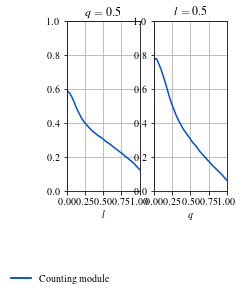

In [ ]:
i = 0
lines = []
for path in paths:
    full_path = os.path.join(base, path)
    if not (path.startswith('noise') or path.startswith('coord')):
        continue
   # target_var = path.split('-')[0]
    target_var = path.split('.')[0]
    logs = torch.load(full_path)
    accs = [x['accs'] for x in logs]
    print(target_var)
    configs = [x['config'][target_var] for x in logs]
    other_configs = [x['config']['noise' if target_var == 'coord' else 'coord'] for x in logs]

    ax = plt.subplot(1, 4, i + 1)
    plt.ylim(0, 1)
    plt.xlim(min(configs), max(configs))
    plt.xticks(np.linspace(min(configs), max(configs), 5, endpoint=True))
    name = name_lookup[target_var]
    plt.xlabel('${}$'.format(name))
    val = str(other_configs[0]) if name == 'l' or other_configs[0] != 0.0 else '10^{-6}'
    plt.title('${}={}$'.format('q' if name == 'l' else 'l', val))
    plt.grid()
    ax.set_prop_cycle(cycler('color', ['#004CDB', '#FF7800']))
    l = plt.plot(configs, accs, '-')
    lines.append(l)

    i += 1

plt.legend(
    list(zip(*lines)),
    ['Counting module', 'Baseline'],
    ncol=2,
    bbox_to_anchor=(-0.5, -0.6),
    loc='lower right',
    frameon=False,
)
#plt.tight_layout()
plt.subplots_adjust(bottom=0.30, top=0.89)
#plt.savefig('acc.pdf')